In [1]:
!rm -rf /content/*

!wget raw.githubusercontent.com/sinthoras50/AIP-project/main/images/frames.csv
!wget raw.githubusercontent.com/sinthoras50/AIP-project/main/images/polygons.mat

target_directory = 'images'
!mkdir -p {target_directory}

frames = []
NUM_IMAGES = 20

assert 0 < NUM_IMAGES <= 100

with open('frames.csv', 'r') as f:
  lines = f.readlines()
  for i, line in enumerate(lines):
    if i == NUM_IMAGES: break

    line = line.strip()
    frames.append(line.split('.')[0])

    image_url = f'raw.githubusercontent.com/sinthoras50/AIP-project/main/images/{line}'
    !wget -P {target_directory} {image_url}

--2024-12-29 07:35:54--  http://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/frames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/frames.csv [following]
--2024-12-29 07:35:55--  https://raw.githubusercontent.com/sinthoras50/AIP-project/main/images/frames.csv
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1600 (1.6K) [text/plain]
Saving to: ‘frames.csv’

frames.csv          100%[===================>]   1.56K  --.-KB/s    in 0s      

2024-12-29 07:35:55 (18.5 MB/s) - ‘frames.csv’ saved [1600/1600]

URL transformed to HTTPS due to an HSTS polic

In [2]:
import scipy.io
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
print(frames)

['frame_0017', 'frame_0018', 'frame_0058', 'frame_0106', 'frame_0138', 'frame_0181', 'frame_0185', 'frame_0264', 'frame_0294', 'frame_0323', 'frame_0361', 'frame_0363', 'frame_0443', 'frame_0487', 'frame_0551', 'frame_0562', 'frame_0588', 'frame_0612', 'frame_0619', 'frame_0663']


In [4]:
mat = scipy.io.loadmat('polygons.mat')
labelled_frames = []

for i, frame in enumerate(frames):
  labelled_frame = {
    'frame': frame,
    'myleft': mat['polygons'][0][i][0],
    'myright': mat['polygons'][0][i][1],
    'yourleft': mat['polygons'][0][i][2],
    'yourright': mat['polygons'][0][i][3]
  }

  labelled_frames.append(labelled_frame)

print(labelled_frames[2]['frame'])

frame_0058


In [5]:
def get_labelled_frame(frame_name):
  labelled_frame = [label for label in labelled_frames if label['frame'] == frame_name]

  if len(labelled_frame) == 0:
    return

  return labelled_frame[0]


def get_segmentation_mask(frame):
  assert type(frame) == dict, 'Frame must be a dictionary'

  img_mask = np.zeros((720, 1280), np.float32)

  if frame['myleft'].shape != (1, 0):
    myleft_points = [(int(x), int(y)) for x, y in frame['myleft']]
    cv2.fillPoly(img_mask, [np.array(myleft_points, dtype=np.int32)], 255)
  if frame['myright'].shape != (1, 0):
    myright_points = [(int(x), int(y)) for x, y in frame['myright']]
    cv2.fillPoly(img_mask, [np.array(myright_points, dtype=np.int32)], 255)
  if frame['yourleft'].shape != (1, 0):
    yourleft_points = [(int(x), int(y)) for x, y in frame['yourleft']]
    cv2.fillPoly(img_mask, [np.array(yourleft_points, dtype=np.int32)], 255)
  if frame['yourright'].shape != (1, 0):
    yourright_points = [(int(x), int(y)) for x, y in frame['yourright']]
    cv2.fillPoly(img_mask, [np.array(yourright_points, dtype=np.int32)], 255)

  return img_mask


frame_0487


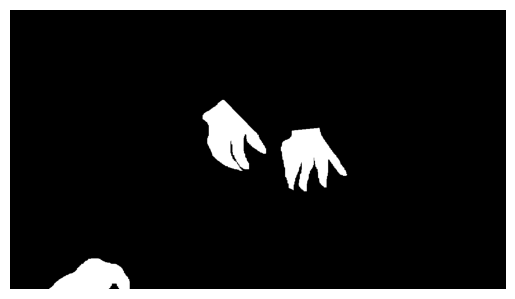

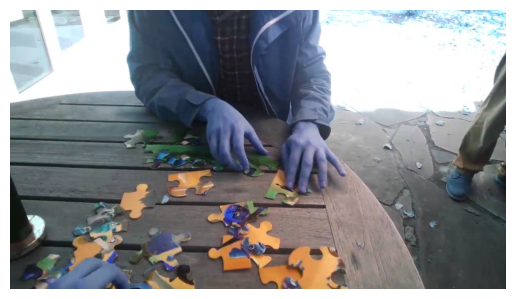

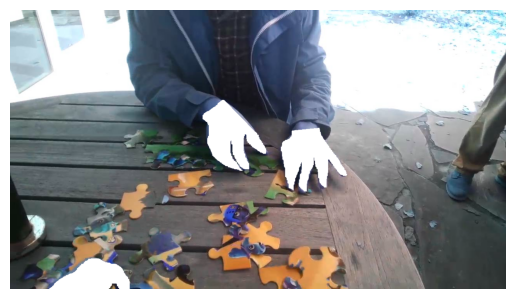

In [6]:
FRAME_NUM = 13

frame_name = labelled_frames[FRAME_NUM]['frame']
print(frame_name)

frame = get_labelled_frame(frame_name)
mask = get_segmentation_mask(frame)

plt.figure()
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

img = cv2.imread(f'images/{frame_name}.jpg')

plt.figure()
plt.imshow(img)
plt.axis('off')
plt.show()

overlayed_img = img.copy()
overlayed_img[mask == 255] = (255, 255, 255)

plt.figure()
plt.imshow(overlayed_img)
plt.axis('off')
plt.show()


# Color-based segmentation


In [35]:
import cv2
import numpy as np


def color_segmentation(img_path):
  image = cv2.imread(img_path)[:, :, ::-1]
  blurred = cv2.GaussianBlur(image, (11, 11), 0)
  hsv_image = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)

  # Define the HSV range for skin detection
  lower_skin = np.array([0, 50, 80])    # Lower bound of HSV for skin
  upper_skin = np.array([20, 255, 255])  # Upper bound of HSV for skin


  skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  skin_mask = cv2.erode(skin_mask, kernel, iterations=3)
  skin_mask = cv2.dilate(skin_mask, kernel, iterations=3)
  skin_mask = cv2.GaussianBlur(skin_mask, (5, 5), 0)

  skin_segment = cv2.bitwise_and(image, image, mask=skin_mask)

  cnts, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  min_contour_area = 10000

  filtered_contours = [cnt for cnt in cnts if cv2.contourArea(cnt) > min_contour_area]

  mask = np.zeros_like(skin_mask)

  cv2.drawContours(mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

  out = cv2.bitwise_and(image, image, mask=mask)

  out_binary = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY)
  out_binary[out_binary>0] = 1

  return out_binary


### dev

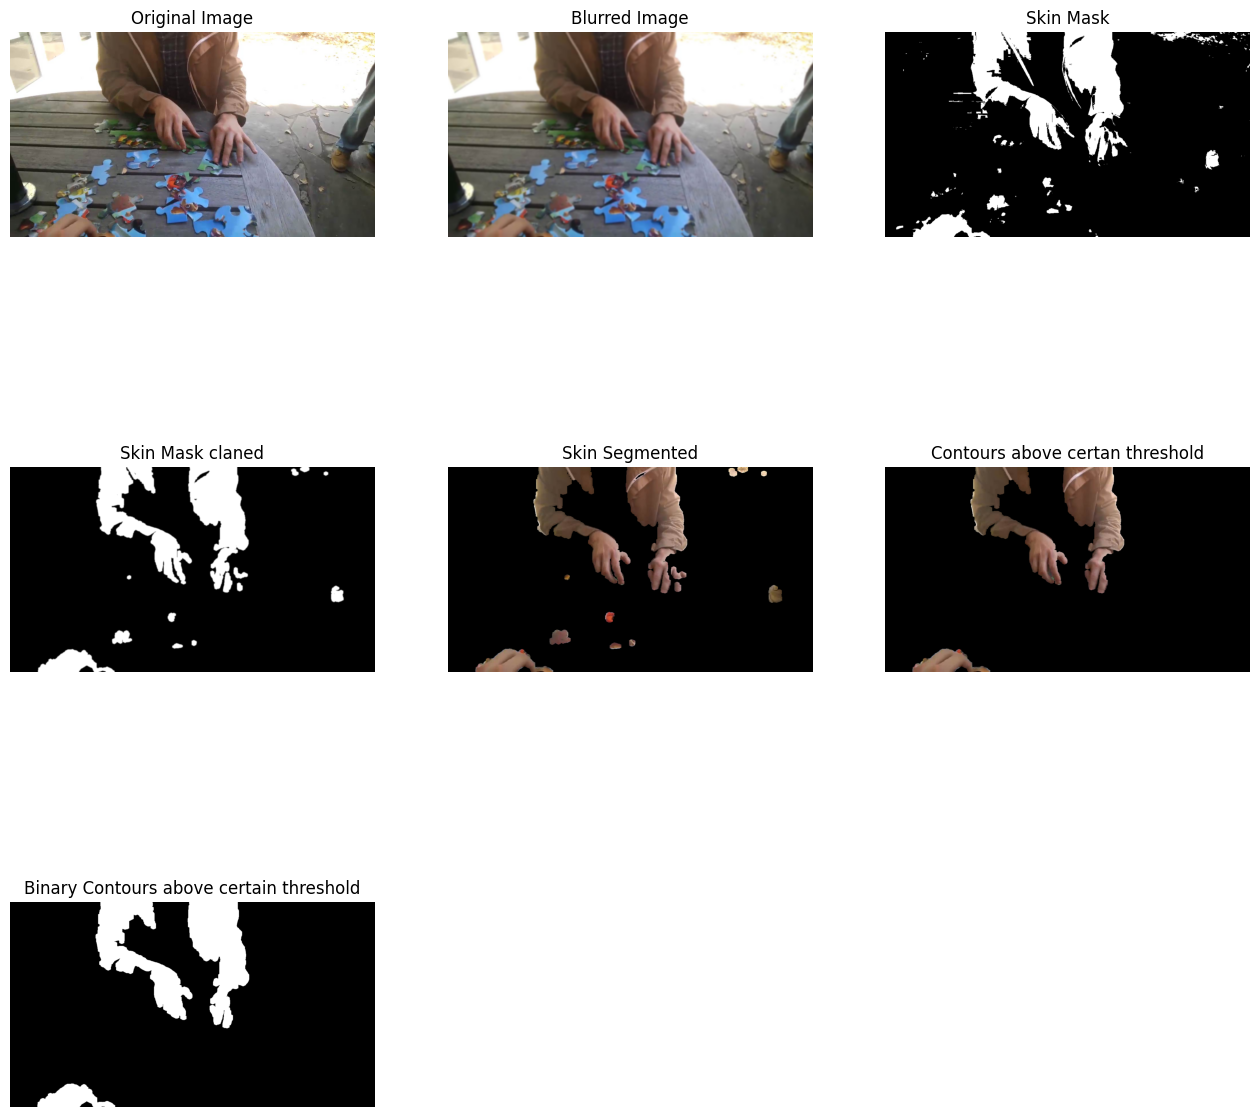

In [48]:
import cv2
import numpy as np

image = cv2.imread(f'images/{frame_name}.jpg')[:, :, ::-1]
# Original image
plt.figure(figsize=(16,16))
plt.subplot(3, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Blurred image
blurred = cv2.GaussianBlur(image, (11, 11), 0)
plt.subplot(3, 3, 2)
plt.imshow(blurred)
plt.title('Blurred Image')
plt.axis('off')

hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Define the HSV range for skin detection
lower_skin = np.array([0, 50, 80])    # Lower bound of HSV for skin
upper_skin = np.array([20, 255, 255])  # Upper bound of HSV for skin

# Skin mask
skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)
plt.subplot(3, 3, 3)
plt.imshow(skin_mask, cmap='gray')
plt.title('Skin Mask')
plt.axis('off')

# Apply morphological operations to clean up the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
skin_mask = cv2.erode(skin_mask, kernel, iterations=3)
skin_mask = cv2.dilate(skin_mask, kernel, iterations=3)
skin_mask = cv2.GaussianBlur(skin_mask, (5, 5), 0)

plt.subplot(3, 3, 4)
plt.imshow(skin_mask, cmap='gray')
plt.title('Skin Mask claned')
plt.axis('off')

# Skin segmented
skin_segment = cv2.bitwise_and(image, image, mask=skin_mask)
plt.subplot(3, 3, 5)
plt.imshow(skin_segment)
plt.title('Skin Segmented')
plt.axis('off')


# Find the largest contour
cnts, _ = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

min_contour_area = 10000
# cnt = max(cnts, key=cv2.contourArea)  # Largest contour by area
filtered_contours = [cnt for cnt in cnts if cv2.contourArea(cnt) > min_contour_area]

# Prepare an output mask
mask = np.zeros_like(skin_mask)  # Create a blank mask

# Draw the largest contour on the mask
cv2.drawContours(mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

# Apply the mask to the original image
out = cv2.bitwise_and(image, image, mask=mask)

# Display the output
plt.subplot(3, 3, 6)
plt.imshow(out)
plt.title('Contours above certan threshold')
plt.axis('off')


out_binary = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY)
out_binary[out_binary>0] = 1
plt.subplot(3, 3, 7)
plt.imshow(out_binary, cmap='gray')
plt.title('Binary Contours above certain threshold')
plt.axis('off')

plt.show()

#IoU metric function

In [46]:
def evaluate_iou(segmented_imgs, ground_truth_imgs):
  total_intersection_area = 0
  total_union_area = 0
  for si, gti in zip(segmented_imgs, ground_truth_imgs):
    intersection = cv2.bitwise_and(si, gti)
    union = cv2.bitwise_or(si, gti)

    total_intersection_area += np.sum(intersection)
    total_union_area += np.sum(union)

  return total_intersection_area / total_union_area if total_union_area > 0 else 0

# Color-based segmentation method evaluation


In [47]:
segmented_images = []
ground_truth_images = []

for img_name in frames:
  segmented_images.append(color_segmentation(f'images/{img_name}.jpg'))
  # TODO this steps need to be extracted into separate method
  frame = get_labelled_frame(img_name)
  mask = get_segmentation_mask(frame)
  binary_overlay = np.zeros(mask.shape, dtype=np.uint8)
  binary_overlay[mask == 255] = 1
  ground_truth_images.append(binary_overlay)
print("acccuracy is: ", evaluate_iou(segmented_images, ground_truth_images))

acccuracy is:  0.30772315567952785
